# Retail Store Clustering Using KNN
Dane Hamlett, UC Davis MSBA '18

<p id="toc"></p>
## Table of Contents

   - <a href="#one">Introduction</a>
   - <a href="#two">Import Libraries</a>
   - <a href="#three">Import Data</a>
   - <a href="#four">Google Distance Matrix API</a>
   - <a href="#five">Initiate EDA</a>
   - <a href="#six">KNN Modeling</a>
   - <a href="#seven">Conclusion</a>

<hr style="width:50%;">
## <a id="one">Introduction</a>
<p><a href="#toc">Jump to top</a></p>
<br>
As part of a practicum project I have been working on, while pursuing my MSBA degree at UC Davis, I encountered a unique data challenge that I aimed to solve using a well-known machine learning algorithm, KNN. The focus of my project was to gain a better understanding for how to improve price perception, for a large grocery chain in the Sacramento region. <strong>Specifically, how is price perception affected by the competition?</strong>
<p></p>
While this is a challenging business question to answer, this business question can be broken up into three key focus areas. Analyzing price perception must take into account which competitive stores should be observed, which products actually drive consumer price perception, and which time period contains the most relevant data.
<p></p>
<strong>This analysis aims to cluster retail stores with their competitor's locations, within the Sacramento area.</strong>

![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/elasticity_image.png)

The K-nearest neighbors classifier is a simple algorithm that stores all available cases and classifies new cases based on a similarity measure (e.g., distance functions). KNN has been used in statistical estimation and pattern recognition as a non-parametric technique.<sup>1</sup> KNN is considered to be a supervised learning method, where a set of classifications is known, and the KNN algorithm is used to predict a classification, based off of a training and test data set. This method is used in both regression and classification methods.
<p></p>
KNN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The KNN algorithm is among the simplest of all machine learning algorithms.<sup>2</sup> A successful implementation of this model will find a balance between <strong>bias</strong> (when an algorithm has limited flexibility to learn the true signal from a dataset), and <strong>variance</strong> (an algorithm's sensitivity to specific sets of training data).<sup>4</sup>

![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/knn_image.png)

1. http://www.saedsayad.com/k_nearest_neighbors.htm
2. https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm
3. https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/
4. https://elitedatascience.com/bias-variance-tradeoff

<hr style="width:50%;">
## <a id="two">Import Libraries</a>
<p><a href="#toc">Jump to top</a></p>

In [844]:
# Import libraries
import numpy as np
import pandas as pd
import urllib.request
import json
import requests
import os
import fnmatch
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Visualization specifications
color = sns.color_palette()
plt.style.use('ggplot')
%matplotlib inline

# Warning message supression
warnings.simplefilter("ignore")

<hr style="width:50%;">
## <a id="three">Import Data</a>
<p><a href="#toc">Jump to top</a></p>

In [845]:
# Import primary store data & preview data
# This data is publicly available here: https://www.raleys.com/www/storelocator?loc=sacramento
stores = pd.read_csv("https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/raleys_stores.csv")
stores.head()

,Store_Id,Store,Address,City,State,Zip,Phone,Hours,Latitude,Longitude
0,1,Aisle1,3250 Arena Blvd,Sacramento,CA,95834,916-419-8844,Grocery Hours: Conven Store 5am - 10pm,38.641751,-121.533688
1,2,Bel Air,1301 Florin Rd.,Sacramento,CA,95831,916-421-6766,Grocery Hours: 6 am - 11 pm,38.496602,-121.510262
2,3,Bel Air,3250 Arena Blvd,Sacramento,CA,95834,916-419-8844,Grocery Hours: 6 am - 11 p.m,38.641751,-121.533688
3,4,Bel Air,1540 W. El Camino Ave.,Sacramento,CA,95833,916-920-2493,Grocery Hours: 6 am - 11 pm,38.611796,-121.496539
4,5,Bel Air,6231 Fruitridge Rd.,Sacramento,CA,95820,916-739-8647,Grocery Hours: 6 am - 11 pm,38.525580,-121.431875


In [846]:
# Remove non-critical columns from data frame & preview data
stores['Coords'] = stores['Latitude'].astype(str) + ',' + stores['Longitude'].astype(str)
stores = stores.drop(['Address', 'City', 'State', 'Zip', 'Phone', 'Hours'],axis=1)
stores.head()

,Store_Id,Store,Latitude,Longitude,Coords
0,1,Aisle1,38.641751,-121.533688,"38.641751,-121.533688"
1,2,Bel Air,38.496602,-121.510262,"38.496602,-121.510262"
2,3,Bel Air,38.641751,-121.533688,"38.641751,-121.533688"
3,4,Bel Air,38.611796,-121.496539,"38.611796,-121.496539"
4,5,Bel Air,38.525580,-121.431875,"38.52558,-121.431875"


In [847]:
# Import competitor store data & preview data
# This data is publicly available and can be aggregated via Google Maps: https://www.google.com/maps
competitors = pd.read_csv("https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/competitor_stores.csv")
competitors.head()

,Store_Id,Id,Store,Zip,Latitude,Longitude
0,1,5326.0,Safeway,95758,38.423279,-121.446152
1,2,33954.0,Walmart Supercenter,95842,38.702492,-121.331200
2,3,165.0,Safeway,95835,38.655998,-121.523880
3,4,74912.0,Walmart,95757,38.391811,-121.417557
4,5,33975.0,Safeway,95842,38.685612,-121.340446


In [848]:
# Remove non-critical columns from data frame
competitors['Coords'] = competitors['Latitude'].astype(str) + ',' + competitors['Longitude'].astype(str)
competitors = competitors.drop(['Id', 'Zip'],axis=1)
competitors.head()

,Store_Id,Store,Latitude,Longitude,Coords
0,1,Safeway,38.423279,-121.446152,"38.423279,-121.446152"
1,2,Walmart Supercenter,38.702492,-121.331200,"38.702492,-121.3312"
2,3,Safeway,38.655998,-121.523880,"38.655998,-121.52388"
3,4,Walmart,38.391811,-121.417557,"38.391811,-121.417557"
4,5,Safeway,38.685612,-121.340446,"38.685612,-121.340446"


Here is a <a href="https://www.latlong.net/convert-address-to-lat-long.html" target="_blank">link to a great tool</a> that will allow you to generate geospatial coordinates from an address.

<hr style="width:50%;">
## <a id="four">Google Distance Matrix API</a>
<p><a href="#toc">Jump to top</a></p>

Under advisement from our practicum stakeholders, it was recommended that we focus on driving distance & duration as a primary metric of proximity, for a primary retail location, and it's competitors locations. The method below is used to query the <a href="https://developers.google.com/maps/documentation/distance-matrix/intro" target="_blank">Google Distance Matrix API</a>, returning driving duration and distance via nested JSON. This API is free of cost, but does require registration, and an API key. Be aware of usage limits, especially as you debug your code, since these limits are relatively easy to exceed.
<p></p>
![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/google_image.png)
<p></p>
The code snippet below is a sample code, which breaks up an API call into smaller batches, to avoid the single call element limit.

In [849]:
## Prepare API call

# api_key = '<your API key goes here'
# base_url = 'https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins='
# store_coords = stores['Coords'].str.cat(sep='|')
# results = []

# ## Batch out API calls, due to individual API call rate limit

# batch_size = 6
# for batch in range(0, len(competitors['Coords']), batch_size):
#     comp_coords = competitors['Coords'][batch:batch+batch_size].str.cat(sep='|')
#     api_call = base_url + store_coords + '&destinations=' + comp_coords + '&key=' + api_key
#     with urllib.request.urlopen(api_call) as url:
#         data = json.loads(url.read().decode())
#         for i,o in enumerate(data['origin_addresses']):
#             for ir,r in enumerate(data['rows'][i]['elements']):
#                 d = data['destination_addresses'][ir]
#                 row = d,o,r['distance']['text'],r['duration']['text']
#                 results.append(row)

# d_results = pd.DataFrame(results)
# d_results.head()

The code snippet below is an alternate method to parse through multiple JSON files, which are stored locally. This is a great strategy for debugging, before pushing code to production.

In [850]:
## Alternate method, if you are able to store files locally
# Setup default variables
results = []
rootPath = './Data'
pattern = '*.json'
batch_size = 6

# Execute for loop, to parse through local files, accounting for the original API call sequence
for folder, subfolders, files in os.walk(rootPath):
    
    # Sorting used to mimic original API call sequence
    for key,file in enumerate(sorted(sorted(fnmatch.filter(files, pattern)),key=len)):
        filePath = os.path.join(os.path.abspath(folder), file)
        with open(filePath) as data_file:
            data = json.load(data_file)
            for i,o in enumerate(data['origin_addresses']):
                for ir,r in enumerate(data['rows'][i]['elements']):
                    oli = stores['Store_Id'][i]
                    ola = stores['Latitude'][i]
                    olo = stores['Longitude'][i]
                    dli = competitors['Store_Id'][(key*batch_size)+ir]
                    dls = competitors['Store'][(key*batch_size)+ir]
                    dla = competitors['Latitude'][(key*batch_size)+ir]
                    dlo = competitors['Longitude'][(key*batch_size)+ir]
                    d = data['destination_addresses'][ir]
                    dist = pd.to_numeric(r['distance']['text'].strip(' mi'))
                    dur = r['duration']['text']
                    row = dli,dls,dla,dlo,d,oli,ola,olo,o,dist,dur
                    results.append(row)

# Store results in a data frame, to allow for manipulation and analysis
df_results = pd.DataFrame(results,columns = ["Dest_Store_Id", "Dest_Store", "Dest_Store_Lat", "Dest_Store_Long", 
                                             "Dest_Store_Address", "Orig_Store_Id", "Orig_Store_Lat",
                                             "Orig_Store_Long", "Orig_Store_Address", "Driving_Distance",
                                             "Driving_Duration"])
# Preview data
df_results.head()

,Dest_Store_Id,Dest_Store,Dest_Store_Lat,Dest_Store_Long,Dest_Store_Address,Orig_Store_Id,Orig_Store_Lat,Orig_Store_Long,Orig_Store_Address,Driving_Distance,Driving_Duration
0,1,Safeway,38.423279,-121.446152,"5057-5105 Laguna Blvd, Elk Grove, CA 95758, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",19.0,23 mins
1,2,Walmart Supercenter,38.702492,-121.331200,"Antelope Rd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",17.2,21 mins
2,3,Safeway,38.655998,-121.523880,"2811 Del Paso Rd, Sacramento, CA 95835, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",2.3,8 mins
3,4,Walmart,38.391811,-121.417557,"10070 Bruceville Rd, Elk Grove, CA 95757, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",22.7,29 mins
4,5,Safeway,38.685612,-121.340446,"5349 Elkhorn Blvd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",13.9,17 mins


In [851]:
# Filter out competitor store locations that are far away
df_results = df_results.loc[df_results['Driving_Distance'] <= 50]

# Convert Driving Distance metrics to a consumable form
df_results['Driving_Duration'] = df_results['Driving_Duration'].str.strip(' mins')
df_results['Driving_Duration'] = df_results['Driving_Duration'].astype(float)

# Preview data
df_results.head()

,Dest_Store_Id,Dest_Store,Dest_Store_Lat,Dest_Store_Long,Dest_Store_Address,Orig_Store_Id,Orig_Store_Lat,Orig_Store_Long,Orig_Store_Address,Driving_Distance,Driving_Duration
0,1,Safeway,38.423279,-121.446152,"5057-5105 Laguna Blvd, Elk Grove, CA 95758, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",19.0,23.0
1,2,Walmart Supercenter,38.702492,-121.331200,"Antelope Rd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",17.2,21.0
2,3,Safeway,38.655998,-121.523880,"2811 Del Paso Rd, Sacramento, CA 95835, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",2.3,8.0
3,4,Walmart,38.391811,-121.417557,"10070 Bruceville Rd, Elk Grove, CA 95757, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",22.7,29.0
4,5,Safeway,38.685612,-121.340446,"5349 Elkhorn Blvd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",13.9,17.0


<hr style="width:50%;">
## <a id="five">Initiate EDA</a>
<p><a href="#toc">Jump to top</a></p>

In order to assess whether driving distance (miles) or duration (minutes) should be leveraged as a better metric to assess proximity between locations, we will want to assess the relationship between these two variables, to see if it makes more sense to use one or the other.

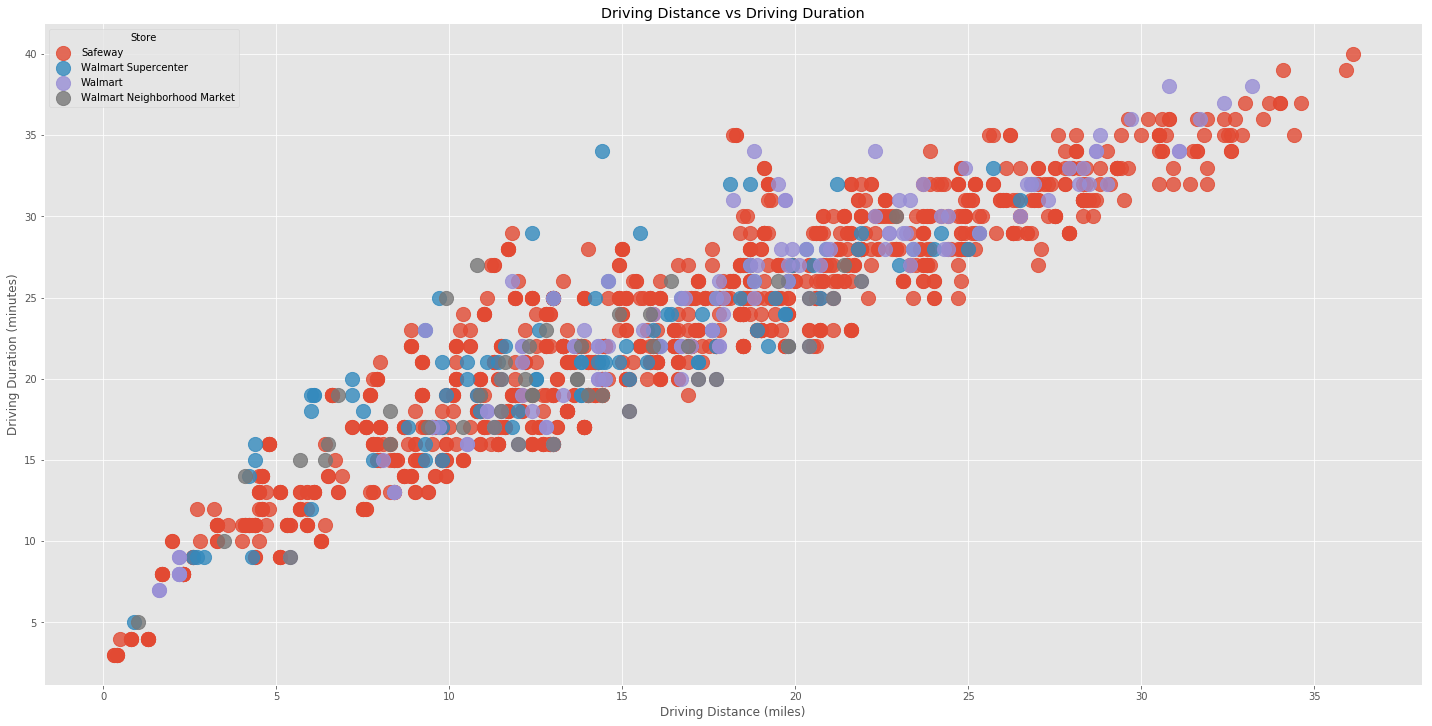

In [852]:
# Generate plot to identify spread of driving metric distributions
ax = sns.lmplot(x='Driving_Distance', y='Driving_Duration', data=df_results, hue='Dest_Store', fit_reg=False, size=10, aspect=2, legend=False, scatter_kws={"s": 200})
ax.set(xlabel='Driving Distance (miles)', ylabel='Driving Duration (minutes)', title="Driving Distance vs Driving Duration")
plt.legend(loc='upper left', title='Store')
plt.show()

Driving distance and driving duration appear to have a fairly strong positive correlation, meaning that for every unit of increase in driving distance, we should expect a comparable unit of increase for driving duration. Let's create a pearson correlation matrix to assess this.

In [853]:
# Create a correlation matrix to assess variable relationship
df_disti = df_results[["Driving_Distance","Driving_Duration"]].copy()
df_disti.corr()

,Driving_Distance,Driving_Duration
Driving_Distance,1.000000,0.920809
Driving_Duration,0.920809,1.000000


Now let's assess the distribution of these two variables to determine how this may affect our modeling choices, and if any transformations are required.

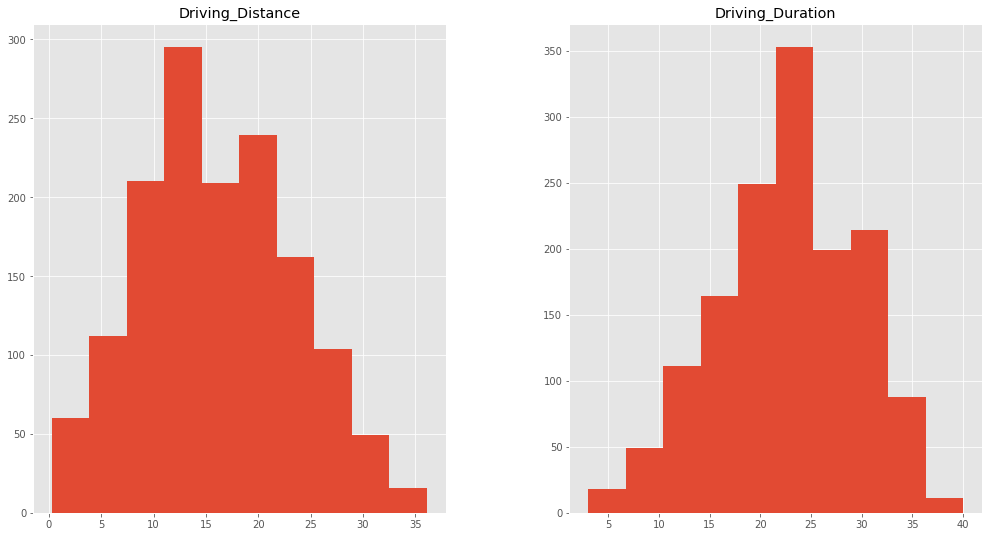

In [854]:
# Create a subset to analyze and confirm the distribution of the data
pd.DataFrame.hist(df_disti, figsize = [17,9])
plt.show()

The data appears to be normally distributed for both driving duration and driving distance. Based off of our correlation and distribution analysis, it would appear as though either of these metrics would serve as a viable feature for our KNN model.
<p></p>
Now let's take a look at how these stores are related, when plotting their geospatial points (latitude and longitude).

In [855]:
# Leverage the folium library for an interactive data visualization
stores_map = folium.Map(location=[38.5816, -121.4944],tiles='Stamen Toner', zoom_start=11)
for name, row in stores.iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Raleys',icon=folium.Icon(color='red',icon='shopping-cart')).add_to(stores_map)
for name, row in competitors.loc[competitors['Store'] == 'Safeway'].iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Safeway',icon=folium.Icon(color='lightred',icon='none')).add_to(stores_map)
for name, row in competitors[competitors['Store'].str.contains('Wal')].iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Walmart',icon=folium.Icon(color='blue',icon='none')).add_to(stores_map)
stores_map

There are quite a few data points avialable on this chart, so we'll need to start to pair this down, and look for additional visual confirmation that we are heading down the right path.
<p></p>
Let's leverage a correlation heat map to see how the data looks.

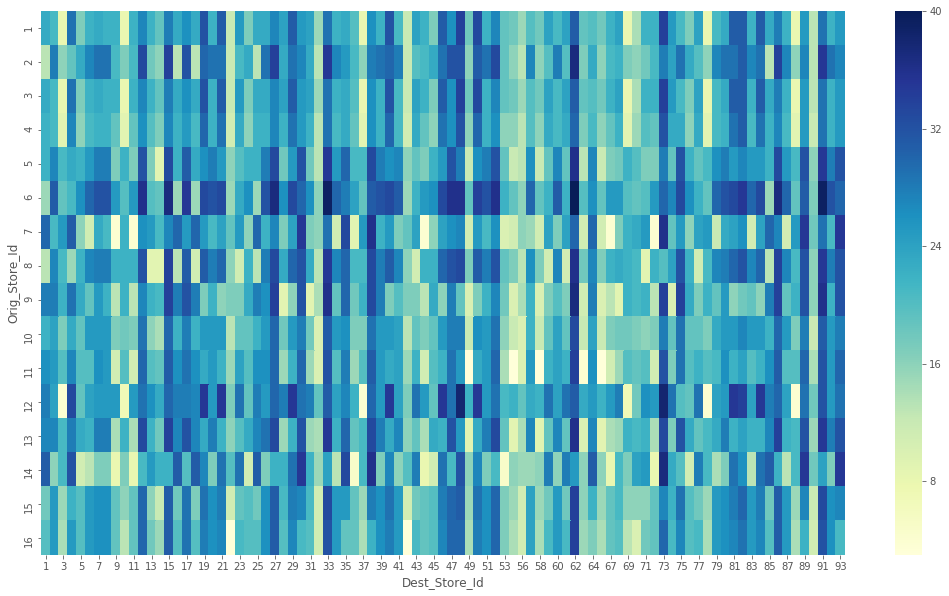

In [856]:
# Create a matrix data frame to feed into a correlation heat map
df_matrix = df_results[["Dest_Store_Id","Orig_Store_Id","Driving_Distance","Driving_Duration"]].copy()
plt.subplots(figsize=(18,10))
duration = df_matrix
duration = duration.pivot("Orig_Store_Id", "Dest_Store_Id", "Driving_Duration")
bx = sns.heatmap(duration,cmap="YlGnBu")

While this may be a visually appealing chart, there are far too many data points to sift through with the human eye. This was a valid attempt to leverage a best-in-class EDA method, but it may not be applicable for our model, with such a large n.
<p></p>
To better understand how we may want to start to cluster stores, let's rank our locations between stores, which will inform our KNN model what we will want to predict. Ideally we want to predict the closest primary store to a competitor's location, so we will rank the locations accordingly.

In [857]:
# Create a ranking for each competitor's location, relative to the closest primary location
df_results['Store_Rank'] = df_results.sort_values(['Driving_Duration'], ascending=[True]) \
             .groupby(['Dest_Store_Id']) \
             .cumcount() + 1

# Create a subset of data to identify the closest location
df_results_1 = df_results.loc[df_results['Store_Rank'] == 1]
df_results_1 = df_results_1[["Dest_Store_Id","Orig_Store_Id"]].copy()

# Merge 5 subsets of data into primary data frame
df_results = pd.merge(df_results, df_results_1, on='Dest_Store_Id', suffixes=('', '_1'), how='left')

# Let's define a color-based array to map clusters
colors = ['white', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkblue', 'darkgreen', 'cadetblue', 'red', 'darkpurple', 
          'pink', 'lightblue', 'lightgreen', 'black']

df_colors = pd.DataFrame(list(enumerate(colors)),columns = ["Orig_Store_Id_1","Color"])
df_results = pd.merge(df_results, df_colors, on='Orig_Store_Id_1', how='left')

# Preview results
df_results.head()

,Dest_Store_Id,Dest_Store,Dest_Store_Lat,Dest_Store_Long,Dest_Store_Address,Orig_Store_Id,Orig_Store_Lat,Orig_Store_Long,Orig_Store_Address,Driving_Distance,Driving_Duration,Store_Rank,Orig_Store_Id_1,Color
0,1,Safeway,38.423279,-121.446152,"5057-5105 Laguna Blvd, Elk Grove, CA 95758, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",19.0,23.0,9,8,darkblue
1,2,Walmart Supercenter,38.702492,-121.331200,"Antelope Rd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",17.2,21.0,5,14,lightblue
2,3,Safeway,38.655998,-121.523880,"2811 Del Paso Rd, Sacramento, CA 95835, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",2.3,8.0,2,12,darkpurple
3,4,Walmart,38.391811,-121.417557,"10070 Bruceville Rd, Elk Grove, CA 95757, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",22.7,29.0,13,8,darkblue
4,5,Safeway,38.685612,-121.340446,"5349 Elkhorn Blvd, Sacramento, CA 95842, USA",1,38.641751,-121.533688,"3250 Arena Blvd, Sacramento, CA 95834, USA",13.9,17.0,4,14,lightblue


Now that we have rankings in place, let's visualize our data, to see how our clusters are starting to form.

In [858]:
# Create additional data frames for plotting
df_results_plot = df_results[["Dest_Store_Id","Dest_Store","Dest_Store_Lat","Dest_Store_Long","Color","Orig_Store_Id_1"]].copy()
df_results_plot = df_results_plot.drop_duplicates()
df_stores_plot = pd.merge(stores, df_colors, how = 'left', left_on = 'Store_Id', right_on = 'Orig_Store_Id_1')

# Leverage the folium library for an interactive data visualization
color_map = folium.Map(location=[38.5816, -121.4944],tiles='Stamen Toner', zoom_start=11)
for name, row in df_stores_plot.iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Raleys',icon=folium.Icon(color=row["Color"],icon='shopping-cart')).add_to(color_map)
for name, row in df_results_plot.iterrows():
    folium.Marker([row["Dest_Store_Lat"], row["Dest_Store_Long"]],popup=row["Dest_Store"],icon=folium.Icon(color=row["Color"],icon='none')).add_to(color_map)
color_map

<hr style="width:50%;">
## <a id="six">KNN Modeling</a>
<p><a href="#toc">Jump to top</a></p>
<p></p>
Let's begin our predictive modeling! We are going to leverage the scikit-learn library, to train a KNN classifier and evaluate the performance. We will use a 4-step process to model the data:

1. Import the algorithm
2. Instantiate the model
3. Train the model
4. Predict the response

In [859]:
# Create the primary data frame for our KNN model
df_knn = df_results.loc[df_results['Store_Rank'] == 1]
df_knn = df_knn[["Dest_Store_Id","Dest_Store_Lat","Dest_Store_Long",\
                             "Driving_Duration","Driving_Distance","Orig_Store_Id_1"]].copy()

# create design matrix X and target vector y
X = np.array(df_knn.ix[:, 3:5])
Z = np.array(df_knn.ix[:, 1:3])
y = np.array(df_knn['Orig_Store_Id_1'])

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# duplicate split to remap clusters (note the same seed, to ensure results are consistent)
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.25, random_state=10)

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3,p=2)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# evaluate accuracy
print(accuracy_score(y_test, pred))

0.652173913043


Now we can assess our model, to find an optimal value of K. Let's run a few simulations to see what our accuracy score looks like.

In [860]:
# Create lists for accuracy analysis
k_values = [1,2,3,4,5,6,7,8,9,10]
accuracy_list = []

# Run simulations
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k,p=2)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    accuracy_list.append(accuracy)
    print(k,accuracy)

1 0.913043478261
2 0.782608695652
3 0.652173913043
4 0.521739130435
5 0.608695652174
6 0.608695652174
7 0.521739130435
8 0.521739130435
9 0.521739130435
10 0.434782608696


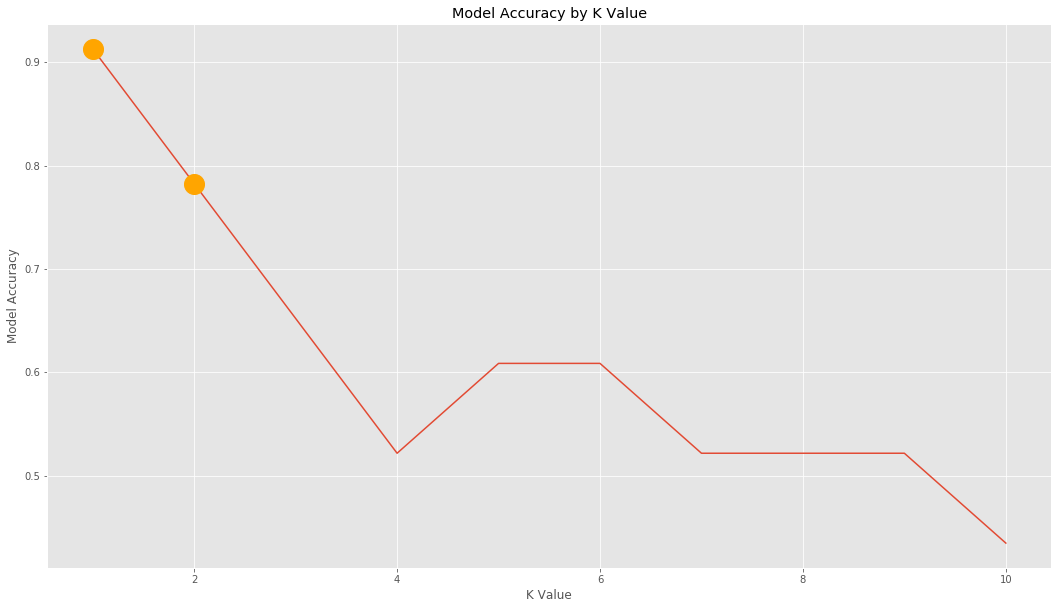

In [861]:
# Plot model accuracy, based off of new values of k
plt.figure(figsize=(18,10))
plt.plot(k_values, accuracy_list)
plt.title('Model Accuracy by K Value')
plt.xlabel('K Value')
plt.ylabel('Model Accuracy')
plt.plot(1, .9130, marker='o', markersize=20, color='orange')
plt.plot(2, .7826, marker='o', markersize=20, color='orange')
plt.show()

Based off of the analysis above, we may want to assume that this accuracy assessment may allow us to determine which K yields the most accurate prediction. However, keep in mind that we're leveraging the same subset of data in each test, as to not account for a level of randomness for each execution. We still need to run a level of cross-validation on the data set, to confirm the value of K that corresponds to the lowest test error rate, this will help us assess the strength of our prediction.
<p></p>
Now let's visulize our modeled data, and compare the results.

In [862]:
# Create a KNN data frame that we can use to plot our predicted cluster
df_cluster = pd.DataFrame(X_test,columns = ["Driving_Duration","Driving_Distance"])
df_cluster = pd.concat([df_cluster, pd.DataFrame(pred), pd.DataFrame(Z_test)], axis=1)
df_cluster.columns.values[[2, 3, 4]] = ['Orig_Store_Pred', 'Latitude', 'Longitude']
df_cluster = pd.merge(df_cluster, df_colors, how = 'left', left_on = 'Orig_Store_Pred', right_on = 'Orig_Store_Id_1')

# Leverage the folium library for an interactive data visualization
cluster_map = folium.Map(location=[38.5816, -121.4944],tiles='Stamen Toner', zoom_start=11)
for name, row in df_stores_plot.iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Raleys',icon=folium.Icon(color=row["Color"],icon='shopping-cart')).add_to(cluster_map)
for name, row in df_cluster.iterrows():
    folium.Marker([row["Latitude"], row["Longitude"]],popup='Prediction',icon=folium.Icon(color=row["Color"],icon='none')).add_to(cluster_map)
cluster_map

<br>
The results of this cluster tend to mirror the original clustering technique, using driving duration and ranking. However, we don't have the same amount of data points avialable (smaller n), and we've optimized our KNN classifier around a value of K that prevents overfitting, but doesn't yeild a 100% level of accuracy. These are the tradeoffs that need to be made in a real-world setting.

![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/comparison_image.png)

Now let's execute a K-fold cross-validation method, to assess the results of 10 estimates of the test error which will then be averaged out to find the misclassification errors. We will then plot these results out, to see if our proposed value of K (3) aligns to our previous accuracy modeling.

In [863]:
# Create an odd list of K for KNN
myList = list(range(1,50))

# Subsetting just the odd ones
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# New list that will hold cv scores
cv_scores = []

# Perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# Create a data frame for visualization
df_neighbors = pd.DataFrame(neighbors,columns = ["K"])
df_scores = pd.DataFrame(cv_scores,columns = ["Score"])
df_scores = pd.concat([df_neighbors,df_scores],axis=1)
df_scores.head()

,K,Score
0,1,0.725714
1,3,0.651310
2,5,0.587976
3,7,0.551310
4,9,0.568095


The optimal number of neighbors is 1.


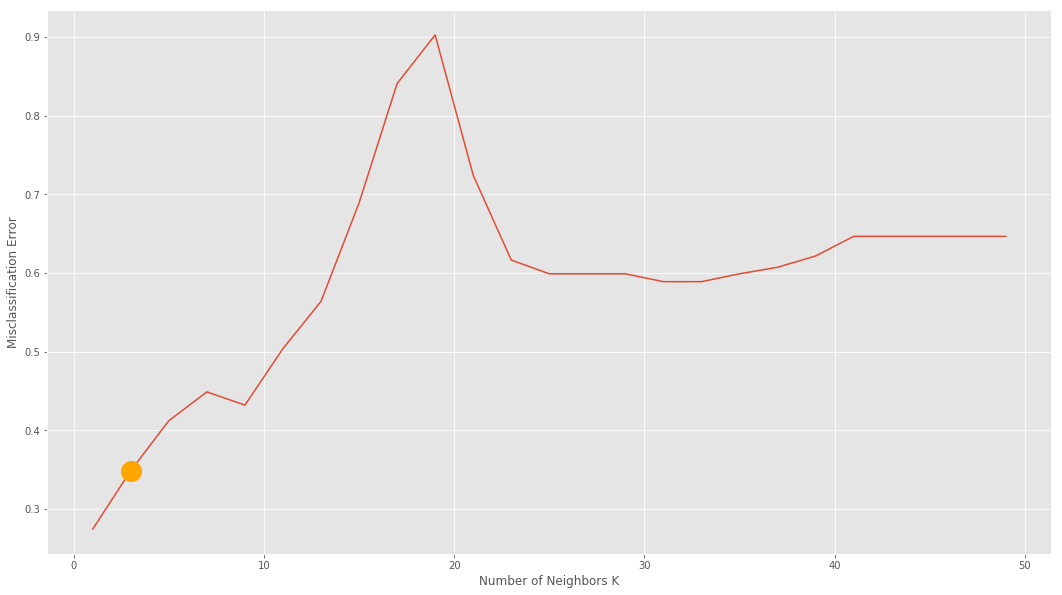

In [864]:
# Changing to misclassification error - Mean Squared Error (values closer to zero are better)
MSE = [1 - x for x in cv_scores]

# Determine the best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k + ".")

# Plot misclassification error vs k
plt.figure(figsize=(18,10))
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.plot(3, .348, marker='o', markersize=20, color='orange')
plt.show()

Though a K value of 1 yeilds the most optimal value of K, that isn't realistic in this model. Because there are 90+ competitor locations that we need to map to primary stores, we'll want to identify groups (or clusters) of multiple stores that will span a shared customer base. In an attempt to find a happy medium for our bias-variance tradeoff, we'll shoot to optimize around a K value of 3, to ensure we minimize our exposure to model overfitting.

<hr style="width:50%;">
## <a id="seven">Conclusion</a>
<p><a href="#toc">Jump to top</a></p>
<p></p>

While this analysis was primarily aimed at answering a fairly straight-forward business question, the process by which we arrived at our conclusion and final answer, was quite a hefty analytic exercise.  We started by compiling two seperate store location data sets, that we wanted to merge.  Though this data is publicly available, we did need to make a decision on how we were going to bridge these data sets, and what unit of measure/metric we wanted to optimize around.  Through discussions with analytics experts in the retail sector, it was advised that driving distance and driving duration were two key metrics that are used to identify competitive store clusters. Leveraging this advice, we connected to the <a href="https://developers.google.com/maps/documentation/distance-matrix/" target="_blank">Google Distance Matrix API</a>, to extract this data, and we started to conduct our EDA.
<p></p>
By conducting EDA, we were able to identify key variables we ultimately wanted to use for our KNN modeling, and made preliminary assumptions around what our potential store clusters would look like. We confirmed that there is a strong positive correlation between driving distance and driving duration, and after analyzing those variables independently, we decided to include both metrics in our model.
<p></p>
When it came time to building our model, we leveraged the KNeighborsClassifier method from the <a href="http://scikit-learn.org/stable/" target="_blank">scikit-learn library</a>, to build our prediction. Behind the scenes, model manipulation was executed to find the optimal number of variables, and k values, to ensure we were properly accounting for a potential overfitting of the model, and establishing a level bias-variance tradeoff. We tested the accuracy of our model, performed a 10-fold cross validation to assess the misclassification error of our model, and arrived at a final prediction.
<p></p>
While this was a fruitful exercise, I would say 90% of the effort was spent on data acquisition, manipulation, and discovery. At times, I did feel like I was trying to solve a rubik's cube, given all of the Data Frame ammendments that were taking place. Another interesting ideology that arose as part of this exercise, was the notion of diminishing return. Given all of the data manipulation, modeling, and tuning that took place . . . <strong>was this model actually better than simply querying the Google Distance Matrix API, and simply ranking locations by driving distance in ascending order?</strong>
<p></p>
In this case, the misclassification of a competitive store may actually have real implications on a company's marketing strategy, causing unexpected financial results.  With more data points, we may have been able to improve the accuracy of our model, but the KNN classification should never be the only driving force behind answering that question. Industry insights, regional consumer behavior, and various other factors also need to play into this decision. So before you head out on your own journey to try solve an incredibly challenging problem, identify that point of diminishing return, and determine if your local grocer's juice is worth the squeeze (pun intended).


![Chart Image](https://raw.githubusercontent.com/danehamlett/UC_Davis/master/Classification/rubiks_image.png)